In [1]:
import pandas as pd
import numpy as np
import json
import sys
sys.path.append('../')
from train_pda_cv import compute_metrics

In [2]:
artifact_folder = '/project/rcde/datasets/pda/model_run_artifacts/pda_cvtest_/'

with open(f"{artifact_folder}/cv_results_val.json", 'r') as f:
    res_val = pd.DataFrame(json.load(f))

with open(f"{artifact_folder}/cv_results_test.json", 'r') as f:
    res_test = pd.DataFrame(json.load(f))

print(res_val.keys())

assert (res_val.keys() == res_test.keys()).all()

Index(['split', 'loss', 'metrics', 'targets', 'outputs', 'external_ids',
       'patient_ids'],
      dtype='object')


In [3]:
df_val, df_test = [pd.concat([d[['split', 'loss']], pd.DataFrame(d.metrics.tolist())], axis=1) for d in (res_val, res_test)]
df_val

,split,loss,roc_auc,accuracy,sensitivity,specificity
0,0,0.372326,0.932634,0.869318,0.838710,0.903614
1,1,0.414246,0.915144,0.818182,0.903226,0.722892
2,2,0.388852,0.882972,0.819742,0.815385,0.825243
3,3,0.369719,0.878075,0.813559,0.823529,0.787879
4,4,0.464855,0.897167,0.852941,0.885167,0.746032
5,5,0.426827,0.903030,0.805085,0.741176,0.969697


# Clip-level results

In [12]:
import statsmodels.stats.api as sms

print("------------------------------------")
print("Clip-level results:")
print("------------------------------------")
print()
print("Validation 95% Confidence Intervals:")
print("------------------------------------")
cols = ['loss', 'roc_auc', 'accuracy', 'sensitivity', 'specificity']
for c in cols:
    mean = df_val[c].mean()
    low, high = sms.DescrStatsW(df_val[c]).tconfint_mean()
    print(f"{c:>11}: {mean:0.3f} [{low:0.3f}, {high:0.3f}]")

print()
print("Test 95% Confidence Intervals:")
print("------------------------------------")
cols = ['loss', 'roc_auc', 'accuracy', 'sensitivity', 'specificity']
for c in cols:
    mean = df_test[c].mean()
    low, high = sms.DescrStatsW(df_test[c]).tconfint_mean()
    print(f"{c:>11}: {mean:0.3f} [{low:0.3f}, {high:0.3f}]")

------------------------------------
Clip-level results:
------------------------------------

Validation 95% Confidence Intervals:
------------------------------------
       loss: 0.406 [0.368, 0.445]
    roc_auc: 0.902 [0.880, 0.923]
   accuracy: 0.830 [0.803, 0.856]
sensitivity: 0.835 [0.774, 0.895]
specificity: 0.826 [0.726, 0.926]

Test 95% Confidence Intervals:
------------------------------------
       loss: 0.481 [0.378, 0.584]
    roc_auc: 0.865 [0.825, 0.904]
   accuracy: 0.771 [0.692, 0.849]
sensitivity: 0.802 [0.710, 0.894]
specificity: 0.769 [0.616, 0.922]


# Study-level results

In [5]:
pat_val = res_val.drop(['loss', 'metrics'], axis=1).explode(column=['targets', 'outputs', 'external_ids', 'patient_ids'])
pat_val['study'] = pat_val.external_ids.str.split('_').str[0]
pat_val

,split,targets,outputs,external_ids,patient_ids,study
0,0,1.0,-7.763616,study86_dicom65,ded498e8adf7852f,study86
0,0,1.0,-6.304462,study86_dicom99,ded498e8adf7852f,study86
0,0,1.0,3.787008,study86_dicom105,ded498e8adf7852f,study86
0,0,1.0,5.327815,study86_dicom108,ded498e8adf7852f,study86
0,0,1.0,2.038718,study86_dicom109,ded498e8adf7852f,study86
...,...,...,...,...,...,...
5,5,1.0,0.875129,study43_dicom7,f8dd48f1f7946612,study43
5,5,1.0,1.976349,study43_dicom9,f8dd48f1f7946612,study43
5,5,1.0,3.327712,study43_dicom13,f8dd48f1f7946612,study43
5,5,1.0,0.723056,study43_dicom18,f8dd48f1f7946612,study43


In [6]:
pat_test = res_test.drop(['loss', 'metrics'], axis=1).explode(column=['targets', 'outputs', 'external_ids', 'patient_ids'])
pat_test['study'] = pat_test.external_ids.str.split('_').str[0]
pat_test

,split,targets,outputs,external_ids,patient_ids,study
0,0,0.0,-2.006141,study42_dicom81,d9d3ed4a1ab8b062,study42
0,0,0.0,-2.989669,study42_dicom50,d9d3ed4a1ab8b062,study42
0,0,0.0,-3.431382,study42_dicom67,d9d3ed4a1ab8b062,study42
0,0,0.0,-2.483953,study42_dicom79,d9d3ed4a1ab8b062,study42
0,0,0.0,-1.088541,study42_dicom85,d9d3ed4a1ab8b062,study42
...,...,...,...,...,...,...
5,5,0.0,0.206901,study55_dicom104,efa3614c94506474,study55
5,5,0.0,-0.323145,study55_dicom95,efa3614c94506474,study55
5,5,0.0,-0.939825,study55_dicom61,efa3614c94506474,study55
5,5,0.0,0.552775,study55_dicom103,efa3614c94506474,study55


In [7]:
# make patient-type level prediction
pat_lvl_preds_val = pat_val.groupby(['split', 'study', 'targets'], as_index=False).apply(lambda x: pd.Series(
    {
        'outputs': x.outputs.astype(np.float32).mean(),
    }))
    
pat_level_mets_val = pat_lvl_preds_val.groupby('split', as_index=False).apply(
        lambda x: pd.Series(compute_metrics(x.targets.astype(int), x.outputs, from_probs=True, threshold=0.5))
    )

# again for test:
pat_lvl_preds_test = pat_test.groupby(['split', 'study', 'targets'], as_index=False).apply(lambda x: pd.Series(
    {
        'outputs': x.outputs.astype(np.float32).mean(),
    }))
    
pat_level_mets_test = pat_lvl_preds_test.groupby('split', as_index=False).apply(
        lambda x: pd.Series(compute_metrics(x.targets.astype(int), x.outputs, from_probs=True, threshold=0.5))
    )

In [13]:
import statsmodels.stats.api as sms

print("------------------------------------")
print("Study-level results:")
print("------------------------------------")
print()
print("Validation 95% Confidence Intervals:")
print("------------------------------------")
cols = ['roc_auc', 'accuracy', 'sensitivity', 'specificity']
for c in cols:
    mean = pat_level_mets_val[c].mean()
    low, high = sms.DescrStatsW(pat_level_mets_val[c]).tconfint_mean()
    print(f"{c:>11}: {mean:0.3f} [{low:0.3f}, {min(high,1):0.3f}]")

print()
print("Test 95% Confidence Intervals:")
print("------------------------------------")
cols = ['roc_auc', 'accuracy', 'sensitivity', 'specificity']
for c in cols:
    mean = pat_level_mets_test[c].mean()
    low, high = sms.DescrStatsW(pat_level_mets_test[c]).tconfint_mean()
    print(f"{c:>11}: {mean:0.3f} [{low:0.3f}, {min(high,1):0.3f}]")

------------------------------------
Study-level results:
------------------------------------

Validation 95% Confidence Intervals:
------------------------------------
    roc_auc: 0.952 [0.900, 1.000]
   accuracy: 0.867 [0.797, 0.936]
sensitivity: 0.844 [0.721, 0.966]
specificity: 0.915 [0.813, 1.000]

Test 95% Confidence Intervals:
------------------------------------
    roc_auc: 0.935 [0.893, 0.977]
   accuracy: 0.862 [0.757, 0.968]
sensitivity: 0.831 [0.719, 0.943]
specificity: 0.932 [0.792, 1.000]


# ROC Plots

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def make_plot(df):
    grid = np.linspace(0,1,500)
    tpr_interps = []
    scores = []
    for grp, d in df.groupby('split'):

        fpr, tpr, eps = roc_curve(d.targets.astype(int), d.outputs)
        # print(fpr)
        # assert False
        score = roc_auc_score(d.targets.astype(int), d.outputs)
        scores.append(score)
        tpr_interps.append(np.interp(grid, fpr, tpr, left=0))

    tpr_interps = np.stack(tpr_interps)
    mean_tpr = tpr_interps.mean(axis=0)
    mean_tpr[0]=0
    mean_score = np.mean(scores)
    
    ci_low = []
    ci_high = []
    for ix, t in enumerate(tpr_interps.T):
        l,h = sms.DescrStatsW(t).tconfint_mean()
        ci_low.append(l)
        ci_high.append(h)

    plt.fill_between(grid, ci_low, ci_high, color='gray', alpha=0.3)
    plt.plot(grid, mean_tpr, 'b-', label=f"CV mean ({mean_score:0.3f})")
    plt.plot(grid, grid, 'k:', label='Baseline (0.500)')
    plt.gca().set_aspect(1)
    plt.legend(loc=4)
    plt.grid()

    plt.xlabel("1 - specificity")
    plt.ylabel("sensitivity")

    plt.gcf().set_size_inches(7,7)
    plt.rcParams['font.size'] = 22

Clip level performance


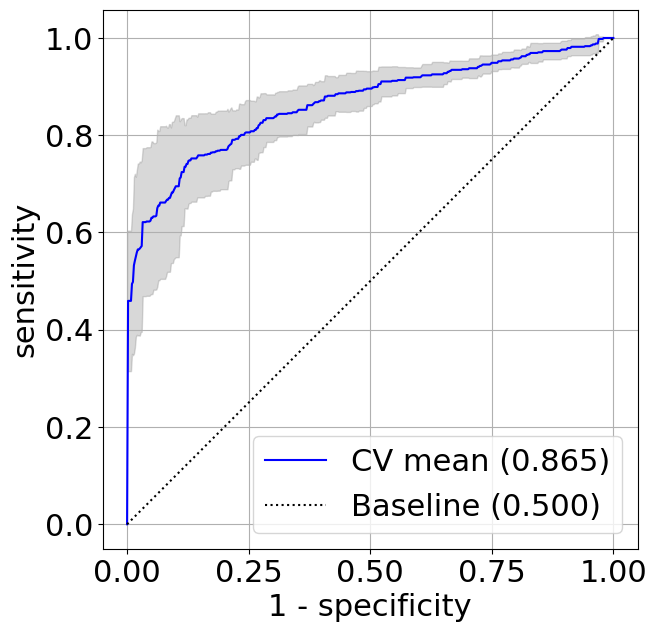

In [23]:
print("Clip level performance")
make_plot(pat_test)
plt.savefig('roc_clip.png', dpi=500)

Patient-level performance


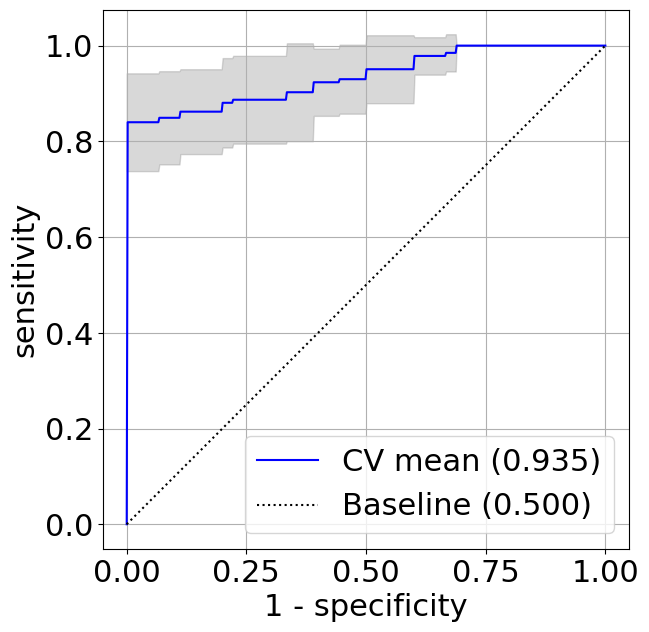

In [24]:
print("Patient-level performance")
make_plot(pat_lvl_preds_test)
plt.savefig('roc_study.png', dpi=500)
